<a href="https://www.kaggle.com/code/dataranch/loan-eligibility-eda-model-comparison?scriptVersionId=106919058" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Loan Eligibility Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

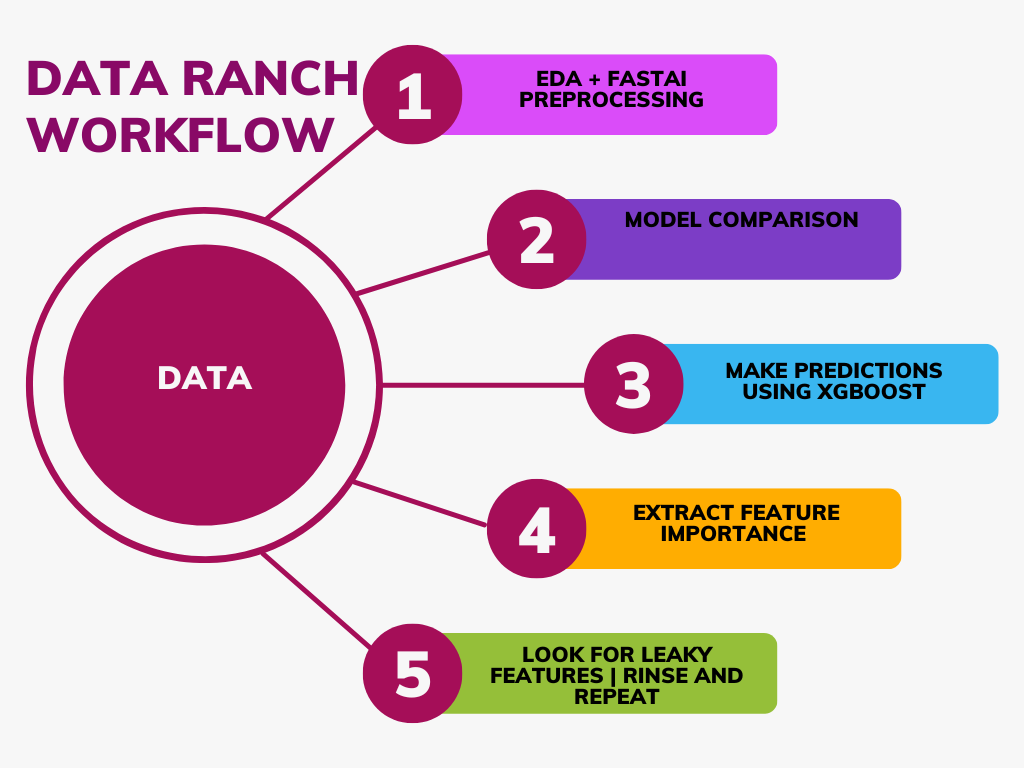

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 950.7 kB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'loan-prediction-with-3-problem-statement'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [10]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/loan-prediction-with-3-problem-statement
CSV!
CSV!
CSV!


In [11]:
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.00,360.00,1.00,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.00,360.00,1.00,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.00,360.00,1.00,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.00,360.00,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.00,360.00,1.00,Urban
...,...,...,...,...,...,...,...,...,...,...,...,...
362,LP002971,Male,Yes,3+,Not Graduate,Yes,4009,1777,113.00,360.00,1.00,Urban
363,LP002975,Male,Yes,0,Graduate,No,4158,709,115.00,360.00,1.00,Urban
364,LP002980,Male,No,0,Graduate,No,3250,1993,126.00,360.00,NaN,Semiurban
365,LP002986,Male,Yes,0,Graduate,No,5000,2393,158.00,360.00,1.00,Rural


In [12]:
df.isna().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
property_Area         0
dtype: int64

In [13]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

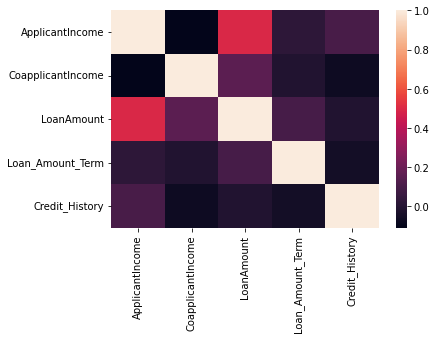

In [14]:
sns.heatmap(df.corr())

In [15]:
df.head().style.background_gradient(cmap = "inferno")

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.00,360.00,1.00,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.00,360.00,1.00,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.00,360.00,1.00,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.00,360.00,nan,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.00,360.00,1.00,Urban


In [16]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,367.00,4805.60,4910.69,0.00,2864.00,3786.00,5060.00,72529.00
CoapplicantIncome,367.00,1569.58,2334.23,0.00,0.00,1025.00,2430.50,24000.00
LoanAmount,362.00,136.13,61.37,28.00,100.25,125.00,158.00,550.00
Loan_Amount_Term,361.00,342.54,65.16,6.00,360.00,360.00,360.00,480.00
Credit_History,338.00,0.83,0.38,0.00,1.00,1.00,1.00,1.00


In [17]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'property_Area'],
      dtype='object')

Target Variable: Credit_History
CATS=====================
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'property_Area']
CONTS=====================
['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
12
Could not convert Loan_ID to float.
Looping through continuous variables to find breakpoint
Error with  Loan_ID
Continuous variables that made the cut : ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
Categorical variables that made the cut : ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'property_Area']
Tabular Object size: 367


 14%|█▍        | 6/42 [00:00<00:00, 57.54it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.11832946133323508, 'Adjusted R-Squared': -0.23876494178450658, 'RMSE': 0.41634374715259825, 'Time taken': 0.02727341651916504}
{'Model': 'BaggingRegressor', 'R-Squared': -0.17645813305507585, 'Adjusted R-Squared': -0.3031536243071611, 'RMSE': 0.42702706524281975, 'Time taken': 0.024549484252929688}
{'Model': 'BayesianRidge', 'R-Squared': -0.00777381113289044, 'Adjusted R-Squared': -0.11630329848566334, 'RMSE': 0.39522890365180835, 'Time taken': 0.025749921798706055}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.6104148711439688, 'Adjusted R-Squared': -0.7838441649594732, 'RMSE': 0.4996156683080882, 'Time taken': 0.007813453674316406}
{'Model': 'DummyRegressor', 'R-Squared': -0.023163662526498596, 'Adjusted R-Squared': -0.13335051849089075, 'RMSE': 0.39823526675514015, 'Time taken': 0.0085601806640625}
{'Model': 'ElasticNet', 'R-Squared': -0.023163662526498596, 'Adjusted R-Squared': -0.13335051849089075, 'RMSE': 0.39823526675514015, 'T

 29%|██▊       | 12/42 [00:00<00:00, 31.18it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.33547693523237987, 'Adjusted R-Squared': -0.47929752825740546, 'RMSE': 0.4549727222468735, 'Time taken': 0.10107207298278809}
{'Model': 'GammaRegressor', 'R-Squared': -0.00795512174401991, 'Adjusted R-Squared': -0.11650413485491451, 'RMSE': 0.3952644552659047, 'Time taken': 0.01052999496459961}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -2.154872803265852, 'Adjusted R-Squared': -2.4946283359252517, 'RMSE': 0.6992912444786794, 'Time taken': 0.03810429573059082}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.06402164496907958, 'Adjusted R-Squared': -0.17860859135036522, 'RMSE': 0.4061087949080195, 'Time taken': 0.0423738956451416}


 38%|███▊      | 16/42 [00:00<00:01, 24.23it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.08680864346786843, 'Adjusted R-Squared': -0.011535041081745856, 'RMSE': 0.37622535411045566, 'Time taken': 0.1737995147705078}
{'Model': 'HuberRegressor', 'R-Squared': -0.23728805462955527, 'Adjusted R-Squared': -0.3705344605127383, 'RMSE': 0.437927858634689, 'Time taken': 0.03146195411682129}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.1559806295399515, 'Adjusted R-Squared': -0.28047085118271564, 'RMSE': 0.42329432100109826, 'Time taken': 0.008896350860595703}
{'Model': 'KernelRidge', 'R-Squared': -21.403947524155708, 'Adjusted R-Squared': -23.8166803344494, 'RMSE': 1.8635001709214634, 'Time taken': 0.015046358108520508}
{'Model': 'Lars', 'R-Squared': -0.011561380304113467, 'Adjusted R-Squared': -0.1204987597214795, 'RMSE': 0.3959709118825314, 'Time taken': 0.013375282287597656}
{'Model': 'LarsCV', 'R-Squared': -0.01260191555290402, 'Adjusted R-Squared': -0.12165135261244764, 'RMSE': 0.3961745158348036, 'Time taken': 0.037

 48%|████▊     | 20/42 [00:00<00:00, 25.03it/s]

{'Model': 'LassoCV', 'R-Squared': -0.01176425123205993, 'Adjusted R-Squared': -0.12072347828782037, 'RMSE': 0.3960106163239331, 'Time taken': 0.08031058311462402}
{'Model': 'LassoLars', 'R-Squared': -0.023163662526498596, 'Adjusted R-Squared': -0.13335051849089075, 'RMSE': 0.39823526675514015, 'Time taken': 0.010888099670410156}
{'Model': 'LassoLarsCV', 'R-Squared': -0.01260191555290402, 'Adjusted R-Squared': -0.12165135261244764, 'RMSE': 0.3961745158348036, 'Time taken': 0.016881227493286133}
{'Model': 'LassoLarsIC', 'R-Squared': -0.010469852899006371, 'Adjusted R-Squared': -0.11928968321120714, 'RMSE': 0.39575721760335947, 'Time taken': 0.011356830596923828}
{'Model': 'LinearRegression', 'R-Squared': -0.011561380304113467, 'Adjusted R-Squared': -0.1204987597214795, 'RMSE': 0.3959709118825315, 'Time taken': 0.008115530014038086}
{'Model': 'LinearSVR', 'R-Squared': -0.23728813559655149, 'Adjusted R-Squared': -0.3705345501992572, 'RMSE': 0.4379278729634876, 'Time taken': 0.0091063976287

 62%|██████▏   | 26/42 [00:01<00:00, 21.55it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.32837525883711005, 'Adjusted R-Squared': -0.4714310559426451, 'RMSE': 0.45376140369607065, 'Time taken': 0.27394938468933105}
{'Model': 'NuSVR', 'R-Squared': -0.10533725546191164, 'Adjusted R-Squared': -0.22437357528088686, 'RMSE': 0.41391824276409234, 'Time taken': 0.020015954971313477}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.013749691442771717, 'Adjusted R-Squared': -0.12292273513660867, 'RMSE': 0.3963989825122984, 'Time taken': 0.00965738296508789}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.013749691442771717, 'Adjusted R-Squared': -0.12292273513660867, 'RMSE': 0.3963989825122984, 'Time taken': 0.013775110244750977}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.188140925085615, 'Adjusted R-Squared': -1.423786870864066, 'RMSE': 0.582377795282831, 'Time taken': 0.010794878005981445}
{'Model': 'PoissonRegressor', 'R-Squared': -0.0063180104146718374, 'Adjusted R-Squared': -0.11469071922855956, 'RMSE': 0.394

 76%|███████▌  | 32/42 [00:01<00:00, 13.68it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.23728813560208262, 'Adjusted R-Squared': -0.37053455020538384, 'RMSE': 0.4379278729644665, 'Time taken': 0.6387484073638916}
{'Model': 'RANSACRegressor', 'R-Squared': -0.23728813559322015, 'Adjusted R-Squared': -0.370534550195567, 'RMSE': 0.4379278729628981, 'Time taken': 0.053801536560058594}


 81%|████████  | 34/42 [00:01<00:00, 12.76it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.15958113141484187, 'Adjusted R-Squared': -0.28445909941336334, 'RMSE': 0.4239530202281901, 'Time taken': 0.15890836715698242}
{'Model': 'Ridge', 'R-Squared': -0.011447354451937564, 'Adjusted R-Squared': -0.12037245416214626, 'RMSE': 0.39594859381365416, 'Time taken': 0.009297370910644531}
{'Model': 'RidgeCV', 'R-Squared': -0.010511875580268448, 'Adjusted R-Squared': -0.11933623141198968, 'RMSE': 0.39576544674867303, 'Time taken': 0.00807499885559082}
{'Model': 'SGDRegressor', 'R-Squared': -0.013749295949526896, 'Adjusted R-Squared': -0.12292229705178359, 'RMSE': 0.39639890518890364, 'Time taken': 0.008046388626098633}
{'Model': 'SVR', 'R-Squared': -0.015642510669410914, 'Adjusted R-Squared': -0.1250193964338091, 'RMSE': 0.39676887742472383, 'Time taken': 0.012767314910888672}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.011561380304113467, 'Adjusted R-Squared': -0.1204987597214795, 'RMSE': 0.3959709118825315, 'Time taken': 0

100%|██████████| 42/42 [00:02<00:00, 17.30it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.6770334505849169, 'Adjusted R-Squared': -0.8576370529556003, 'RMSE': 0.50984484, 'Time taken': 0.2640104293823242}
{'Model': 'LGBMRegressor', 'R-Squared': 0.02868997214927116, 'Adjusted R-Squared': -0.07591264623465355, 'RMSE': 0.3880128421334541, 'Time taken': 0.11469817161560059}
Project: loan-prediction-with-3-problem-statement
loan-prediction-with-3-problem-statement
Target: Credit_History
Credit_History
Target Standard Deviation: 0.43399014714929474
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HistGradientBoostingRegressor               -0.01       0.09  0.38        0.17
LGBMRegressor                               -0.08       0.03  0.39        0.11
PoissonRegressor                            -0.11      -0.01  0.39        0.01
TweedieRegressor                            -0.12      -0.01  0.40        0.01
BayesianRidge            

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,12.913573,4.943892,2.223486,00:00
1,9.402148,6.411105,2.532016,00:00


Better model found at epoch 0 with _rmse value: 2.2234864234924316.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       1.60
1       1       1.67
2       2       1.98
3       2       1.98
4       2       1.46
XGBoost RMSE:  0.50895023


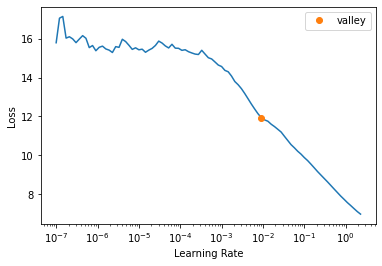

<Figure size 720x720 with 0 Axes>

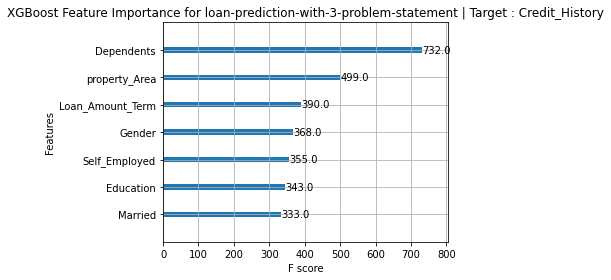

Target Variable: Loan_Amount_Term
CATS=====================
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'property_Area']
CONTS=====================
['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
12
Could not convert Loan_ID to float.
Looping through continuous variables to find breakpoint
Error with  Loan_ID
Continuous variables that made the cut : ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
Categorical variables that made the cut : ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'property_Area']
Tabular Object size: 367


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.08619947538344275, 'Adjusted R-Squared': -0.20317480350165962, 'RMSE': 2.129403191646722, 'Time taken': 0.015854358673095703}


 17%|█▋        | 7/42 [00:00<00:00, 56.34it/s]

{'Model': 'BaggingRegressor', 'R-Squared': -0.2921988182266937, 'Adjusted R-Squared': -0.4313586909587992, 'RMSE': 2.322564459607506, 'Time taken': 0.024951696395874023}
{'Model': 'BayesianRidge', 'R-Squared': -0.007210722633310018, 'Adjusted R-Squared': -0.11567956968612814, 'RMSE': 2.0505165392241884, 'Time taken': 0.009559392929077148}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.4971731377309132, 'Adjusted R-Squared': -0.6584071679480885, 'RMSE': 2.4999948816596844, 'Time taken': 0.008175134658813477}
{'Model': 'DummyRegressor', 'R-Squared': -0.007289959010830627, 'Adjusted R-Squared': -0.11576733921199711, 'RMSE': 2.0505971938000567, 'Time taken': 0.007430076599121094}
{'Model': 'ElasticNet', 'R-Squared': -0.007289959010830627, 'Adjusted R-Squared': -0.11576733921199711, 'RMSE': 2.0505971938000567, 'Time taken': 0.007919788360595703}
{'Model': 'ElasticNetCV', 'R-Squared': -0.007289959010830627, 'Adjusted R-Squared': -0.11576733921199711, 'RMSE': 2.0505971938000567, 'Time tak

 43%|████▎     | 18/42 [00:00<00:00, 25.95it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.06441650555407463, 'Adjusted R-Squared': -0.17904597538297495, 'RMSE': 2.1079432106202103, 'Time taken': 0.13991498947143555}
{'Model': 'HuberRegressor', 'R-Squared': -0.09929874921693216, 'Adjusted R-Squared': -0.21768476836337114, 'RMSE': 2.142204726727604, 'Time taken': 0.039510250091552734}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.21441337768587587, 'Adjusted R-Squared': -0.3451963568212779, 'RMSE': 2.2515747913617905, 'Time taken': 0.010816574096679688}
{'Model': 'KernelRidge', 'R-Squared': -20.914983126565794, 'Adjusted R-Squared': -23.27505823250365, 'RMSE': 9.564751179288887, 'Time taken': 0.023483753204345703}
{'Model': 'Lars', 'R-Squared': -0.005781587466893168, 'Adjusted R-Squared': -0.1140965276556356, 'RMSE': 2.049061279922481, 'Time taken': 0.02278733253479004}
{'Model': 'LarsCV', 'R-Squared': -0.007289959010830627, 'Adjusted R-Squared': -0.11576733921199711, 'RMSE': 2.0505971938000567, 'Time taken': 0.050

 52%|█████▏    | 22/42 [00:00<00:00, 28.66it/s]

{'Model': 'LassoCV', 'R-Squared': -0.007289959010830627, 'Adjusted R-Squared': -0.11576733921199711, 'RMSE': 2.0505971938000567, 'Time taken': 0.062380313873291016}
{'Model': 'LassoLars', 'R-Squared': -0.007289959010830627, 'Adjusted R-Squared': -0.11576733921199711, 'RMSE': 2.0505971938000567, 'Time taken': 0.007681131362915039}
{'Model': 'LassoLarsCV', 'R-Squared': -0.007289959010830627, 'Adjusted R-Squared': -0.11576733921199711, 'RMSE': 2.0505971938000567, 'Time taken': 0.014841556549072266}
{'Model': 'LassoLarsIC', 'R-Squared': -0.007289959010830627, 'Adjusted R-Squared': -0.11576733921199711, 'RMSE': 2.0505971938000567, 'Time taken': 0.009733200073242188}
{'Model': 'LinearRegression', 'R-Squared': -0.005781587466893168, 'Adjusted R-Squared': -0.1140965276556356, 'RMSE': 2.049061279922481, 'Time taken': 0.007471561431884766}
{'Model': 'LinearSVR', 'R-Squared': -0.0992987503378775, 'Adjusted R-Squared': -0.2176847696050337, 'RMSE': 2.1422047278197978, 'Time taken': 0.00761961936950

 62%|██████▏   | 26/42 [00:01<00:00, 20.62it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.3660215902000581, 'Adjusted R-Squared': -0.5131316076062182, 'RMSE': 2.387986614384696, 'Time taken': 0.28987884521484375}
{'Model': 'NuSVR', 'R-Squared': -0.10043705576893602, 'Adjusted R-Squared': -0.21894566177482155, 'RMSE': 2.143313549398027, 'Time taken': 0.03154706954956055}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.005694800106995079, 'Adjusted R-Squared': -0.10138422141994408, 'RMSE': 2.037337418349162, 'Time taken': 0.010068416595458984}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.0022810048219537027, 'Adjusted R-Squared': -0.110218959187395, 'RMSE': 2.045492333848831, 'Time taken': 0.014780521392822266}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.20019166954434486, 'Adjusted R-Squared': -0.3294430801106589, 'RMSE': 2.238352135301093, 'Time taken': 0.009940147399902344}
{'Model': 'PoissonRegressor', 'R-Squared': -0.00511063018948632, 'Adjusted R-Squared': -0.11335331344066191, 'RMSE': 2.04837770112

 83%|████████▎ | 35/42 [00:02<00:00, 12.83it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.09929875033558422, 'Adjusted R-Squared': -0.21768476960249328, 'RMSE': 2.142204727817563, 'Time taken': 0.7391908168792725}
{'Model': 'RANSACRegressor', 'R-Squared': -0.0992987503371392, 'Adjusted R-Squared': -0.2176847696042159, 'RMSE': 2.1422047278190783, 'Time taken': 0.020185470581054688}
{'Model': 'RandomForestRegressor', 'R-Squared': -0.22963504601498186, 'Adjusted R-Squared': -0.36205728173967233, 'RMSE': 2.265641664337518, 'Time taken': 0.1466677188873291}
{'Model': 'Ridge', 'R-Squared': -0.00575509639024907, 'Adjusted R-Squared': -0.11406718369381452, 'RMSE': 2.0490342948406677, 'Time taken': 0.007941722869873047}
{'Model': 'RidgeCV', 'R-Squared': -0.005532937701410168, 'Adjusted R-Squared': -0.11382110022310066, 'RMSE': 2.048807979351775, 'Time taken': 0.009720802307128906}
{'Model': 'SGDRegressor', 'R-Squared': -0.006193324701210701, 'Adjusted R-Squared': -0.11455260582287963, 'RMSE': 2.0494806495493685, 'Time taken': 0.00791430

100%|██████████| 42/42 [00:02<00:00, 17.31it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.4598181407713806, 'Adjusted R-Squared': -0.6170293251621448, 'RMSE': 2.46861, 'Time taken': 0.24865412712097168}
{'Model': 'LGBMRegressor', 'R-Squared': -0.05932751382685031, 'Adjusted R-Squared': -0.1734089383928188, 'RMSE': 2.1028981187317317, 'Time taken': 0.03952670097351074}
Project: loan-prediction-with-3-problem-statement
loan-prediction-with-3-problem-statement
Target: Loan_Amount_Term
Loan_Amount_Term
Target Standard Deviation: 1.5835296940136148
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
OrthogonalMatchingPursuit                   -0.10       0.01  2.04        0.01
OrthogonalMatchingPursuitCV                 -0.11      -0.00  2.05        0.01
TweedieRegressor                            -0.11      -0.00  2.05        0.01
GammaRegressor                              -0.11      -0.00  2.05        0.01
PoissonRegressor        

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,68.897446,76.736237,8.759922,00:00
1,47.628933,32.143242,5.669501,00:00
2,39.487682,21.253397,4.610141,00:00
3,31.095829,25.292854,5.029200,00:00


Better model found at epoch 0 with _rmse value: 8.75992202758789.
Better model found at epoch 1 with _rmse value: 5.669501304626465.
Better model found at epoch 2 with _rmse value: 4.610140800476074.
No improvement since epoch 2: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0      10       9.93
1      10       8.53
2      10       9.64
3      10       9.96
4      10       8.65
XGBoost RMSE:  2.46861


<Figure size 432x288 with 0 Axes>

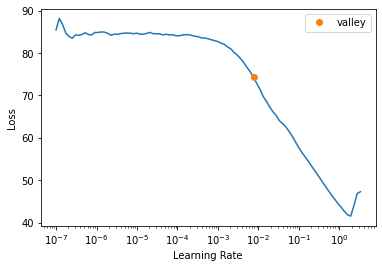

<Figure size 720x720 with 0 Axes>

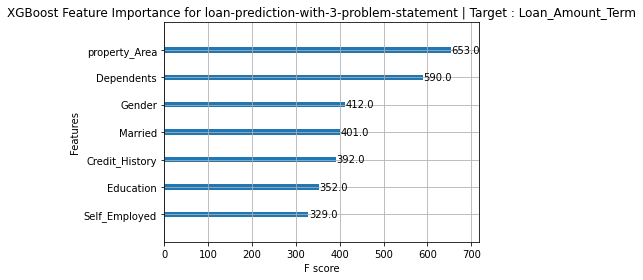

Target Variable: LoanAmount
CATS=====================
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'property_Area']
CONTS=====================
['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome']
11
Could not convert Loan_ID to float.
Looping through continuous variables to find breakpoint
Error with  Loan_ID
Continuous variables that made the cut : ['ApplicantIncome', 'CoapplicantIncome']
Categorical variables that made the cut : ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'property_Area']
Tabular Object size: 367


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.08184386557406831, 'Adjusted R-Squared': -0.21707434877082687, 'RMSE': 83.31171532339518, 'Time taken': 0.034801483154296875}


 14%|█▍        | 6/42 [00:00<00:00, 58.86it/s]

{'Model': 'BaggingRegressor', 'R-Squared': -0.16747170531485334, 'Adjusted R-Squared': -0.3134056684792099, 'RMSE': 86.54599292571906, 'Time taken': 0.02942371368408203}
{'Model': 'BayesianRidge', 'R-Squared': -0.036035241958778164, 'Adjusted R-Squared': -0.16553964720362546, 'RMSE': 81.52879946984416, 'Time taken': 0.011798620223999023}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.20938873216685128, 'Adjusted R-Squared': -0.3605623236877076, 'RMSE': 88.08597016004555, 'Time taken': 0.009932279586791992}
{'Model': 'DummyRegressor', 'R-Squared': -0.0773465000282294, 'Adjusted R-Squared': -0.21201481253175802, 'RMSE': 83.13837, 'Time taken': 0.0075604915618896484}
{'Model': 'ElasticNet', 'R-Squared': -0.037190893547731196, 'Adjusted R-Squared': -0.16683975524119754, 'RMSE': 81.57425768556368, 'Time taken': 0.007892608642578125}
{'Model': 'ElasticNetCV', 'R-Squared': -0.046613448767509835, 'Adjusted R-Squared': -0.17744012986344848, 'RMSE': 81.94395825288152, 'Time taken': 0.0539629

 29%|██▊       | 12/42 [00:00<00:01, 29.32it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.2646494439478124, 'Adjusted R-Squared': -0.42273062444128895, 'RMSE': 90.07595217050887, 'Time taken': 0.10724210739135742}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.5701575776226733, 'Adjusted R-Squared': -0.7664272748255074, 'RMSE': 100.36803061448275, 'Time taken': 0.023665904998779297}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.029681361140763807, 'Adjusted R-Squared': -0.15839153128335925, 'RMSE': 81.27841176861483, 'Time taken': 0.07647967338562012}


 38%|███▊      | 16/42 [00:00<00:01, 25.39it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.06477143764654558, 'Adjusted R-Squared': -0.19786786735236372, 'RMSE': 82.65173589855202, 'Time taken': 0.14654874801635742}
{'Model': 'HuberRegressor', 'R-Squared': -0.0632433617717576, 'Adjusted R-Squared': -0.19614878199322727, 'RMSE': 82.59240698298096, 'Time taken': 0.01281881332397461}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.0009937008414182547, 'Adjusted R-Squared': -0.1261179134465955, 'RMSE': 80.138176, 'Time taken': 0.009280920028686523}
{'Model': 'KernelRidge', 'R-Squared': -3.5112901424573026, 'Adjusted R-Squared': -4.075201410264466, 'RMSE': 170.12735997416206, 'Time taken': 0.02496647834777832}
{'Model': 'Lars', 'R-Squared': -0.030857926715729844, 'Adjusted R-Squared': -0.159715167555196, 'RMSE': 81.3248349062703, 'Time taken': 0.027425765991210938}
{'Model': 'LarsCV', 'R-Squared': -0.0576009242243023, 'Adjusted R-Squared': -0.1898010397523402, 'RMSE': 82.37296408070031, 'Time taken': 0.04173851013183594}

 48%|████▊     | 20/42 [00:00<00:00, 24.62it/s]

{'Model': 'LassoCV', 'R-Squared': -0.0532872248240186, 'Adjusted R-Squared': -0.18494812792702087, 'RMSE': 82.204802694378, 'Time taken': 0.0728294849395752}
{'Model': 'LassoLars', 'R-Squared': -0.07734645565134746, 'Adjusted R-Squared': -0.21201476260776597, 'RMSE': 83.13836445084638, 'Time taken': 0.012029170989990234}
{'Model': 'LassoLarsCV', 'R-Squared': -0.0576009242243023, 'Adjusted R-Squared': -0.1898010397523402, 'RMSE': 82.37296408070031, 'Time taken': 0.01966691017150879}
{'Model': 'LassoLarsIC', 'R-Squared': -0.04098163943637867, 'Adjusted R-Squared': -0.17110434436592592, 'RMSE': 81.72319133726837, 'Time taken': 0.01340627670288086}
{'Model': 'LinearRegression', 'R-Squared': -0.030857926715729844, 'Adjusted R-Squared': -0.159715167555196, 'RMSE': 81.3248349062703, 'Time taken': 0.008667469024658203}
{'Model': 'LinearSVR', 'R-Squared': -0.3174202256687506, 'Adjusted R-Squared': -0.48209775387734455, 'RMSE': 91.93607238797644, 'Time taken': 0.008997917175292969}


 62%|██████▏   | 26/42 [00:01<00:00, 20.85it/s]

{'Model': 'MLPRegressor', 'R-Squared': -1.9331573571227456, 'Adjusted R-Squared': -2.2998020267630888, 'RMSE': 137.18021026289455, 'Time taken': 0.28365015983581543}
{'Model': 'NuSVR', 'R-Squared': -0.07899775500615558, 'Adjusted R-Squared': -0.21387247438192514, 'RMSE': 83.20205508668575, 'Time taken': 0.015941619873046875}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.08532762375493563, 'Adjusted R-Squared': -0.22099357672430253, 'RMSE': 83.4457478756886, 'Time taken': 0.009881734848022461}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.04510106923406032, 'Adjusted R-Squared': -0.17573870288831794, 'RMSE': 81.88473143499463, 'Time taken': 0.014199495315551758}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.17098527257149487, 'Adjusted R-Squared': -0.31735843164293165, 'RMSE': 86.67612743738462, 'Time taken': 0.009016275405883789}
{'Model': 'PoissonRegressor', 'R-Squared': -0.029581503039874057, 'Adjusted R-Squared': -0.15827919091985843, 'RMSE': 81.2744704

 76%|███████▌  | 32/42 [00:01<00:00, 12.21it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.13220053465436332, 'Adjusted R-Squared': -0.27372560148615865, 'RMSE': 85.22862083187538, 'Time taken': 0.7691836357116699}
{'Model': 'RANSACRegressor', 'R-Squared': -0.24160347532583204, 'Adjusted R-Squared': -0.396803909741561, 'RMSE': 89.25144223412973, 'Time taken': 0.11152005195617676}


 81%|████████  | 34/42 [00:02<00:00, 11.33it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.15687003675317812, 'Adjusted R-Squared': -0.30147879134732536, 'RMSE': 86.152139936017, 'Time taken': 0.13387417793273926}
{'Model': 'Ridge', 'R-Squared': -0.030846312045358815, 'Adjusted R-Squared': -0.15970210105102867, 'RMSE': 81.32437676175468, 'Time taken': 0.01199650764465332}
{'Model': 'RidgeCV', 'R-Squared': -0.030799418586852534, 'Adjusted R-Squared': -0.15964934591020907, 'RMSE': 81.32252700752174, 'Time taken': 0.010933637619018555}
{'Model': 'SGDRegressor', 'R-Squared': -0.03156946671023286, 'Adjusted R-Squared': -0.16051565004901192, 'RMSE': 81.352896916167, 'Time taken': 0.009874820709228516}
{'Model': 'SVR', 'R-Squared': -0.11765620951313638, 'Adjusted R-Squared': -0.25736323570227837, 'RMSE': 84.67942504675376, 'Time taken': 0.013231992721557617}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.030857926715729844, 'Adjusted R-Squared': -0.159715167555196, 'RMSE': 81.3248349062703, 'Time taken': 0.0085391998291015

100%|██████████| 42/42 [00:02<00:00, 16.51it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.26688361396882154, 'Adjusted R-Squared': -0.42524406571492435, 'RMSE': 90.15549, 'Time taken': 0.26556396484375}
{'Model': 'LGBMRegressor', 'R-Squared': -0.06654053540801597, 'Adjusted R-Squared': -0.19985810233401802, 'RMSE': 82.7203695560504, 'Time taken': 0.040068626403808594}
Project: loan-prediction-with-3-problem-statement
loan-prediction-with-3-problem-statement
Target: LoanAmount
LoanAmount
Target Standard Deviation: 56.94926071166992
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
KNeighborsRegressor                         -0.13      -0.00  80.14   
PoissonRegressor                            -0.16      -0.03  81.27   
GradientBoostingRegressor                   -0.16      -0.03  81.28   
RidgeCV                                     -0.16      -0.03  81.32   
Ridge                                       -0.16      -0.03  81.32   
Lars          

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,20114.404297,29193.671875,170.861557,00:00
1,19167.763672,27588.722656,166.098526,00:00
2,17673.908203,20677.402344,143.796387,00:00
3,14845.872070,7004.763184,83.694466,00:00
4,12457.932617,22050.650391,148.494598,00:00


Better model found at epoch 0 with _rmse value: 170.86155700683594.
Better model found at epoch 1 with _rmse value: 166.09852600097656.
Better model found at epoch 2 with _rmse value: 143.79638671875.
Better model found at epoch 3 with _rmse value: 83.69446563720703.
No improvement since epoch 3: early stopping


,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,property_Area,LoanAmount,LoanAmount_pred
0,3.00,1.00,2.00,1.00,2.00,12.00,1.00,1.00,200.00,152.69
1,1.00,1.00,2.00,1.00,2.00,12.00,2.00,3.00,101.00,130.69
2,3.00,1.00,2.00,1.00,2.00,12.00,2.00,1.00,130.00,124.76
3,3.00,2.00,2.00,1.00,2.00,12.00,1.00,2.00,105.00,131.36
4,3.00,2.00,2.00,1.00,2.00,12.00,2.00,1.00,126.00,131.68
5,2.00,2.00,2.00,1.00,2.00,12.00,2.00,3.00,185.00,137.50
6,3.00,1.00,2.00,1.00,2.00,12.00,2.00,1.00,131.00,124.76
7,3.00,2.00,4.00,2.00,2.00,12.00,2.00,2.00,150.00,133.61
8,3.00,1.00,2.00,1.00,2.00,12.00,2.00,2.00,120.00,124.65


<Figure size 432x288 with 0 Axes>

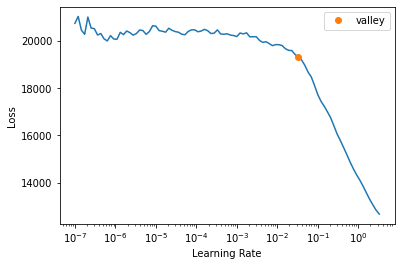

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  100.00     169.87
1  134.00     137.13
2   55.00      91.61
3  185.00     104.63
4  163.00     183.49
XGBoost RMSE:  90.09191


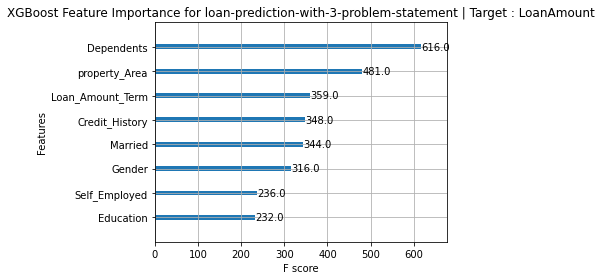

Target Variable: CoapplicantIncome
CATS=====================
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'property_Area']
CONTS=====================
['Loan_ID', 'ApplicantIncome', 'LoanAmount']
11
Could not convert Loan_ID to float.
Looping through continuous variables to find breakpoint
Error with  Loan_ID
Continuous variables that made the cut : ['ApplicantIncome', 'LoanAmount']
Categorical variables that made the cut : ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'property_Area']
Tabular Object size: 367


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.9232079203699914, 'Adjusted R-Squared': -1.1636089104162401, 'RMSE': 2787.205119392078, 'Time taken': 0.024910926818847656}
{'Model': 'BaggingRegressor', 'R-Squared': -1.285082764153866, 'Adjusted R-Squared': -1.5707181096730993, 'RMSE': 3038.132977918188, 'Time taken': 0.023666858673095703}
{'Model': 'BayesianRidge', 'R-Squared': -0.11018490724861474, 'Adjusted R-Squared': -0.24895802065469153, 'RMSE': 2117.646530395789, 'Time taken': 0.01029205322265625}


 17%|█▋        | 7/42 [00:00<00:00, 50.57it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': -1.6183570629072377, 'Adjusted R-Squared': -1.9456516957706422, 'RMSE': 3252.1475915531055, 'Time taken': 0.012325763702392578}
{'Model': 'DummyRegressor', 'R-Squared': -0.029846551118094977, 'Adjusted R-Squared': -0.15857737000785677, 'RMSE': 2039.5862, 'Time taken': 0.009063005447387695}
{'Model': 'ElasticNet', 'R-Squared': -0.13938286443591674, 'Adjusted R-Squared': -0.28180572249040625, 'RMSE': 2145.3129453476995, 'Time taken': 0.008352041244506836}
{'Model': 'ElasticNetCV', 'R-Squared': -0.1330424765084337, 'Adjusted R-Squared': -0.274672786071988, 'RMSE': 2139.3355462331997, 'Time taken': 0.04935717582702637}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -1.3850848927897617, 'Adjusted R-Squared': -1.683220504388482, 'RMSE': 3103.9000818266077, 'Time taken': 0.009940624237060547}
{'Model': 'ExtraTreesRegressor', 'R-Squared': -1.2591492351454954, 'Adjusted R-Squared': -1.5415428895386825, 'RMSE': 3020.8438155393897, 'Time taken': 0.104

 31%|███       | 13/42 [00:00<00:01, 23.06it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.5535058149608731, 'Adjusted R-Squared': -0.7476940418309823, 'RMSE': 2505.0260885549505, 'Time taken': 0.1668555736541748}
{'Model': 'HuberRegressor', 'R-Squared': -0.07760055544929378, 'Adjusted R-Squared': -0.21230062488045554, 'RMSE': 2086.338223899185, 'Time taken': 0.01413273811340332}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.8664467523063621, 'Adjusted R-Squared': -1.0997525963446573, 'RMSE': 2745.7664, 'Time taken': 0.009290695190429688}


 48%|████▊     | 20/42 [00:00<00:00, 30.62it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.6772066433614647, 'Adjusted R-Squared': -0.8868574737816479, 'RMSE': 2602.849746729993, 'Time taken': 0.014067411422729492}
{'Model': 'Lars', 'R-Squared': -0.2331288718237572, 'Adjusted R-Squared': -0.3872699808017268, 'RMSE': 2231.8245201058294, 'Time taken': 0.012616634368896484}
{'Model': 'LarsCV', 'R-Squared': -0.16038662431686346, 'Adjusted R-Squared': -0.30543495235647145, 'RMSE': 2164.996350543336, 'Time taken': 0.022031545639038086}
{'Model': 'Lasso', 'R-Squared': -0.23188326089060274, 'Adjusted R-Squared': -0.38586866850192814, 'RMSE': 2230.6970274841538, 'Time taken': 0.009941339492797852}
{'Model': 'LassoCV', 'R-Squared': -0.15304811192718715, 'Adjusted R-Squared': -0.2971791259180856, 'RMSE': 2158.1395618543943, 'Time taken': 0.06291031837463379}
{'Model': 'LassoLars', 'R-Squared': -0.21147549041083402, 'Adjusted R-Squared': -0.36290992671218825, 'RMSE': 2212.1426433637716, 'Time taken': 0.012346029281616211}
{'Model': 'LassoLarsCV',

 62%|██████▏   | 26/42 [00:01<00:00, 23.85it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.3925852059269166, 'Adjusted R-Squared': -0.5666583566677812, 'RMSE': 2371.7379357834284, 'Time taken': 0.2826404571533203}
{'Model': 'NuSVR', 'R-Squared': -0.000165652923769688, 'Adjusted R-Squared': -0.12518635953924084, 'RMSE': 2009.9802018329506, 'Time taken': 0.015747785568237305}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.07185558040020235, 'Adjusted R-Squared': -0.20583752795022758, 'RMSE': 2080.769379863272, 'Time taken': 0.011366128921508789}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.17931985926201155, 'Adjusted R-Squared': -0.3267348416697631, 'RMSE': 2182.5872685193813, 'Time taken': 0.014384269714355469}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.04611120826897208, 'Adjusted R-Squared': -0.17687510930259354, 'RMSE': 2055.6290155617066, 'Time taken': 0.0108795166015625}
{'Model': 'PoissonRegressor', 'R-Squared': -0.24632016412387192, 'Adjusted R-Squared': -0.402110184639356, 'RMSE': 2243.7301424

 76%|███████▌  | 32/42 [00:01<00:00, 12.10it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.0025064608784752807, 'Adjusted R-Squared': -0.1278197684882847, 'RMSE': 2012.330926406441, 'Time taken': 0.8909790515899658}
{'Model': 'RANSACRegressor', 'R-Squared': -0.15737859567876522, 'Adjusted R-Squared': -0.3020509201386108, 'RMSE': 2162.1884084260882, 'Time taken': 0.10326337814331055}


 83%|████████▎ | 35/42 [00:02<00:00, 12.11it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -1.211686285424845, 'Adjusted R-Squared': -1.4881470711029507, 'RMSE': 2988.9425941474597, 'Time taken': 0.13088202476501465}
{'Model': 'Ridge', 'R-Squared': -0.23203941983255993, 'Adjusted R-Squared': -0.38604434731162995, 'RMSE': 2230.8384094884454, 'Time taken': 0.009233951568603516}
{'Model': 'RidgeCV', 'R-Squared': -0.222682353377748, 'Adjusted R-Squared': -0.3755176475499664, 'RMSE': 2222.350901832213, 'Time taken': 0.009566545486450195}
{'Model': 'SGDRegressor', 'R-Squared': -0.2265651366520458, 'Adjusted R-Squared': -0.37988577873355145, 'RMSE': 2225.8767837571163, 'Time taken': 0.008530378341674805}
{'Model': 'SVR', 'R-Squared': -0.0012185991936941587, 'Adjusted R-Squared': -0.12637092409290585, 'RMSE': 2011.0379488276956, 'Time taken': 0.012582540512084961}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.23312887182375674, 'Adjusted R-Squared': -0.38726998080172637, 'RMSE': 2231.824520105829, 'Time taken': 0.008516550064

100%|██████████| 42/42 [00:02<00:00, 15.81it/s]

{'Model': 'XGBRegressor', 'R-Squared': -1.3540317610124553, 'Adjusted R-Squared': -1.648285731139012, 'RMSE': 3083.628, 'Time taken': 0.3508915901184082}
{'Model': 'LGBMRegressor', 'R-Squared': -0.4991480328419713, 'Adjusted R-Squared': -0.6865415369472176, 'RMSE': 2460.809933230174, 'Time taken': 0.03910422325134277}
Project: loan-prediction-with-3-problem-statement
loan-prediction-with-3-problem-statement
Target: CoapplicantIncome
CoapplicantIncome
Target Standard Deviation: 2399.17724609375
                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
NuSVR                                       -0.13      -0.00 2009.98   
SVR                                         -0.13      -0.00 2011.04   
QuantileRegressor                           -0.13      -0.00 2012.33   
DummyRegressor                              -0.16      -0.03 2039.59   
PassiveAggressiveRegressor                  -0.18      -0.05 2055.63 

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,8990644.000000,5705290.500000,2388.574951,00:00
1,8992130.000000,5694505.000000,2386.316162,00:00
2,8639005.000000,5643059.500000,2375.512451,00:00
3,8713250.000000,5383954.500000,2320.335205,00:00
4,8665220.000000,4521865.000000,2126.467529,00:00
5,8431712.000000,5074479.000000,2252.660400,00:00


Better model found at epoch 0 with _rmse value: 2388.574951171875.
Better model found at epoch 1 with _rmse value: 2386.316162109375.
Better model found at epoch 2 with _rmse value: 2375.512451171875.
Better model found at epoch 3 with _rmse value: 2320.335205078125.
Better model found at epoch 4 with _rmse value: 2126.467529296875.
No improvement since epoch 4: early stopping


,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,property_Area,CoapplicantIncome,CoapplicantIncome_pred
0,3.00,1.00,2.00,2.00,2.00,7.00,2.00,3.00,0.00,654.26
1,3.00,2.00,2.00,2.00,2.00,7.00,2.00,1.00,1600.00,630.89
2,3.00,2.00,4.00,2.00,1.00,7.00,1.00,1.00,2912.00,505.66
3,3.00,1.00,2.00,1.00,2.00,0.00,2.00,3.00,0.00,624.06
4,3.00,2.00,2.00,1.00,2.00,0.00,2.00,1.00,2291.00,609.38
5,3.00,1.00,2.00,2.00,2.00,7.00,2.00,3.00,0.00,654.26
6,2.00,2.00,4.00,2.00,2.00,7.00,2.00,2.00,0.00,534.47
7,3.00,2.00,3.00,1.00,1.00,0.00,2.00,3.00,1775.00,612.90
8,3.00,2.00,4.00,2.00,2.00,7.00,2.00,3.00,3333.00,604.08


<Figure size 432x288 with 0 Axes>

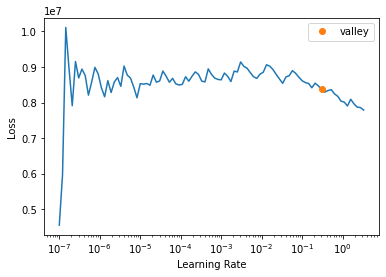

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0 2374.00     597.43
1    0.00    1353.13
2    0.00     539.73
3 2546.00     932.30
4  296.00    1366.64
XGBoost RMSE:  3085.2693


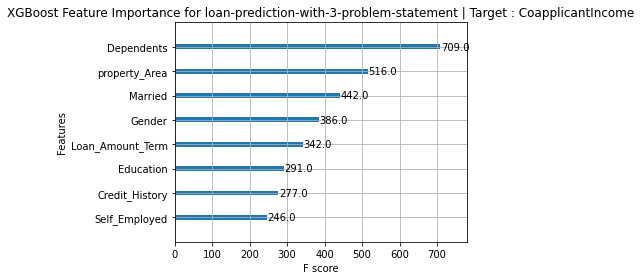

Target Variable: ApplicantIncome
CATS=====================
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'property_Area']
CONTS=====================
['Loan_ID', 'CoapplicantIncome', 'LoanAmount']
11
Could not convert Loan_ID to float.
Looping through continuous variables to find breakpoint
Error with  Loan_ID
Continuous variables that made the cut : ['CoapplicantIncome', 'LoanAmount']
Categorical variables that made the cut : ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'property_Area']
Tabular Object size: 367


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -1.402763290402778, 'Adjusted R-Squared': -1.7031087017031252, 'RMSE': 4364.284980659656, 'Time taken': 0.019887685775756836}
{'Model': 'BaggingRegressor', 'R-Squared': -1.2091363501452737, 'Adjusted R-Squared': -1.4852783939134326, 'RMSE': 4184.743740149103, 'Time taken': 0.023442745208740234}
{'Model': 'BayesianRidge', 'R-Squared': 0.05553873881274174, 'Adjusted R-Squared': -0.06251891883566563, 'RMSE': 2736.2116149887906, 'Time taken': 0.012179136276245117}


 17%|█▋        | 7/42 [00:00<00:00, 50.78it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': -1.4125521123703315, 'Adjusted R-Squared': -1.714121126416623, 'RMSE': 4373.165960712225, 'Time taken': 0.011845111846923828}
{'Model': 'DummyRegressor', 'R-Squared': -0.0004142178523460771, 'Adjusted R-Squared': -0.12546599508388923, 'RMSE': 2816.0964, 'Time taken': 0.008464336395263672}
{'Model': 'ElasticNet', 'R-Squared': 0.052199219602181546, 'Adjusted R-Squared': -0.06627587794754586, 'RMSE': 2741.044829670174, 'Time taken': 0.007746696472167969}
{'Model': 'ElasticNetCV', 'R-Squared': 0.05233961143259169, 'Adjusted R-Squared': -0.06611793713833425, 'RMSE': 2740.8418151970127, 'Time taken': 0.05385732650756836}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -1.0221394349653727, 'Adjusted R-Squared': -1.2749068643360442, 'RMSE': 4003.715015718002, 'Time taken': 0.013407468795776367}
{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.9884315900576388, 'Adjusted R-Squared': -1.2369855388148436, 'RMSE': 3970.2050236009663, 'Time taken': 0.110

 43%|████▎     | 18/42 [00:00<00:00, 26.39it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.5130907248967607, 'Adjusted R-Squared': -0.7022270655088558, 'RMSE': 3463.299833704217, 'Time taken': 0.13906574249267578}
{'Model': 'HuberRegressor', 'R-Squared': -0.009474382891835997, 'Adjusted R-Squared': -0.13565868075331555, 'RMSE': 2828.8196409698353, 'Time taken': 0.015129804611206055}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.2652883946515341, 'Adjusted R-Squared': -0.4234494439829759, 'RMSE': 3167.0315, 'Time taken': 0.009157419204711914}
{'Model': 'KernelRidge', 'R-Squared': -2.8002631722183366, 'Adjusted R-Squared': -3.2752960687456287, 'RMSE': 5488.636179015018, 'Time taken': 0.0387418270111084}
{'Model': 'Lars', 'R-Squared': 0.0010839203076337123, 'Adjusted R-Squared': -0.12378058965391214, 'RMSE': 2813.9871475557256, 'Time taken': 0.02395153045654297}
{'Model': 'LarsCV', 'R-Squared': 0.020325375141174162, 'Adjusted R-Squared': -0.10213395296617911, 'RMSE': 2786.7533837035608, 'Time taken': 0.05041956901550

 52%|█████▏    | 22/42 [00:00<00:00, 28.52it/s]

{'Model': 'LassoCV', 'R-Squared': 0.028160454042461036, 'Adjusted R-Squared': -0.09331948920223132, 'RMSE': 2775.587296778664, 'Time taken': 0.06050586700439453}
{'Model': 'LassoLars', 'R-Squared': 0.008803259724520673, 'Adjusted R-Squared': -0.11509633280991416, 'RMSE': 2803.0932141808253, 'Time taken': 0.008899211883544922}
{'Model': 'LassoLarsCV', 'R-Squared': 0.020325375141174162, 'Adjusted R-Squared': -0.10213395296617911, 'RMSE': 2786.7533837035608, 'Time taken': 0.015689611434936523}
{'Model': 'LassoLarsIC', 'R-Squared': 0.039860388682768866, 'Adjusted R-Squared': -0.08015706273188505, 'RMSE': 2758.829118053112, 'Time taken': 0.010634899139404297}
{'Model': 'LinearRegression', 'R-Squared': 0.0010839203076334902, 'Adjusted R-Squared': -0.12378058965391237, 'RMSE': 2813.987147555726, 'Time taken': 0.008132457733154297}
{'Model': 'LinearSVR', 'R-Squared': -2.5180811429786614, 'Adjusted R-Squared': -2.957841285850994, 'RMSE': 5280.93149156556, 'Time taken': 0.01069784164428711}


 62%|██████▏   | 26/42 [00:01<00:00, 20.10it/s]

{'Model': 'MLPRegressor', 'R-Squared': -2.802520090304826, 'Adjusted R-Squared': -3.2778351015929292, 'RMSE': 5490.265745583845, 'Time taken': 0.2997562885284424}
{'Model': 'NuSVR', 'R-Squared': -0.08228416306598896, 'Adjusted R-Squared': -0.21756968344923755, 'RMSE': 2929.0599407656296, 'Time taken': 0.01594376564025879}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.08467702307139402, 'Adjusted R-Squared': -0.22026165095531836, 'RMSE': 2932.296133664048, 'Time taken': 0.009927034378051758}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.007423313188778535, 'Adjusted R-Squared': -0.11664877266262419, 'RMSE': 2805.0437721520066, 'Time taken': 0.014681816101074219}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.05537867782804873, 'Adjusted R-Squared': -0.18730101255655485, 'RMSE': 2892.4227272840985, 'Time taken': 0.010581254959106445}
{'Model': 'PoissonRegressor', 'R-Squared': -0.008849267080572654, 'Adjusted R-Squared': -0.1349554254656442, 'RMSE': 2827.943633

 76%|███████▌  | 32/42 [00:02<00:01,  9.15it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.12621182445267465, 'Adjusted R-Squared': -0.266988302509259, 'RMSE': 2987.9109433310764, 'Time taken': 1.1307032108306885}
{'Model': 'RANSACRegressor', 'R-Squared': -0.34450973863201884, 'Adjusted R-Squared': -0.5125734559610211, 'RMSE': 3264.672219349172, 'Time taken': 0.11080265045166016}


 81%|████████  | 34/42 [00:02<00:00,  8.94it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.6991037556258983, 'Adjusted R-Squared': -0.9114917250791357, 'RMSE': 3670.0126179029644, 'Time taken': 0.13462233543395996}
{'Model': 'Ridge', 'R-Squared': 0.0019705068190607467, 'Adjusted R-Squared': -0.12278317982855658, 'RMSE': 2812.7380952487006, 'Time taken': 0.011949777603149414}
{'Model': 'RidgeCV', 'R-Squared': 0.009313794226926797, 'Adjusted R-Squared': -0.11452198149470738, 'RMSE': 2802.371228290318, 'Time taken': 0.008829832077026367}
{'Model': 'SGDRegressor', 'R-Squared': -0.004488563967177894, 'Adjusted R-Squared': -0.13004963446307505, 'RMSE': 2821.8251887781935, 'Time taken': 0.0084228515625}
{'Model': 'SVR', 'R-Squared': -0.12401201170418785, 'Adjusted R-Squared': -0.2645135131672114, 'RMSE': 2984.9913960309896, 'Time taken': 0.012299060821533203}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.0010839203076334902, 'Adjusted R-Squared': -0.12378058965391237, 'RMSE': 2813.987147555726, 'Time taken': 0.008359909057

100%|██████████| 42/42 [00:02<00:00, 14.31it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.9867671068764681, 'Adjusted R-Squared': -1.2351129952360265, 'RMSE': 3968.5427, 'Time taken': 0.2738044261932373}
{'Model': 'LGBMRegressor', 'R-Squared': -0.4979250211727224, 'Adjusted R-Squared': -0.6851656488193127, 'RMSE': 3445.899801947095, 'Time taken': 0.04129767417907715}
Project: loan-prediction-with-3-problem-statement
loan-prediction-with-3-problem-statement
Target: ApplicantIncome
ApplicantIncome
Target Standard Deviation: 5296.37158203125
                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
TweedieRegressor                            -0.06       0.06 2735.62   
BayesianRidge                               -0.06       0.06 2736.21   
ElasticNetCV                                -0.07       0.05 2740.84   
ElasticNet                                  -0.07       0.05 2741.04   
LassoLarsIC                                 -0.08       0.04 2758.83   

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,53402728.000000,30575626.000000,5529.522949,00:00
1,51482852.000000,30539968.000000,5526.297852,00:00
2,44916472.000000,30377578.000000,5511.585938,00:00
3,46198060.000000,29084978.000000,5393.048828,00:00
4,47897688.000000,25639242.000000,5063.520996,00:00
5,48713420.000000,13951681.000000,3735.194580,00:00
6,48271964.000000,26579648.000000,5155.545410,00:00


Better model found at epoch 0 with _rmse value: 5529.52294921875.
Better model found at epoch 1 with _rmse value: 5526.2978515625.
Better model found at epoch 2 with _rmse value: 5511.5859375.
Better model found at epoch 3 with _rmse value: 5393.048828125.
Better model found at epoch 4 with _rmse value: 5063.52099609375.
Better model found at epoch 5 with _rmse value: 3735.194580078125.
No improvement since epoch 5: early stopping


,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,property_Area,ApplicantIncome,ApplicantIncome_pred
0,3.00,2.00,3.00,1.00,2.00,11.00,1.00,2.00,4796.00,2665.13
1,2.00,2.00,5.00,1.00,2.00,11.00,2.00,2.00,6260.00,2665.13
2,3.00,1.00,1.00,1.00,2.00,5.00,2.00,3.00,2066.00,2653.22
3,3.00,2.00,1.00,1.00,2.00,11.00,1.00,3.00,3016.00,2662.92
4,3.00,2.00,2.00,1.00,2.00,11.00,2.00,3.00,9226.00,2654.59
5,3.00,1.00,2.00,1.00,2.00,11.00,2.00,1.00,5708.00,2654.94
6,3.00,2.00,4.00,1.00,3.00,11.00,2.00,3.00,4246.00,1600.92
7,3.00,1.00,2.00,2.00,2.00,11.00,2.00,3.00,2868.00,2535.87
8,2.00,1.00,2.00,1.00,2.00,9.00,2.00,3.00,3767.00,2678.37


<Figure size 432x288 with 0 Axes>

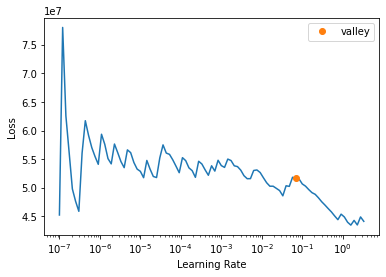

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0 3666.00    3381.68
1 7350.00    9279.74
2 2431.00    2390.89
3 5041.00    4684.03
4 7500.00    4684.03
XGBoost RMSE:  3969.0166


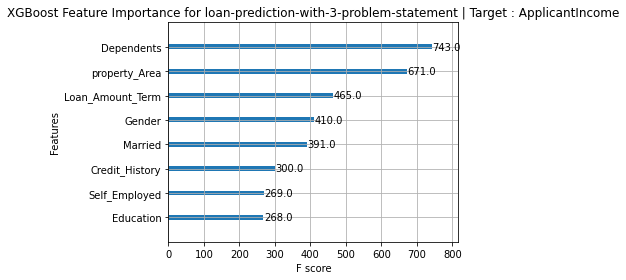

<Figure size 432x288 with 0 Axes>

In [18]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

         feature  importance
0         Gender      316.00
1        Married      344.00
2     Dependents      616.00
3      Education      232.00
4  Self_Employed      236.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

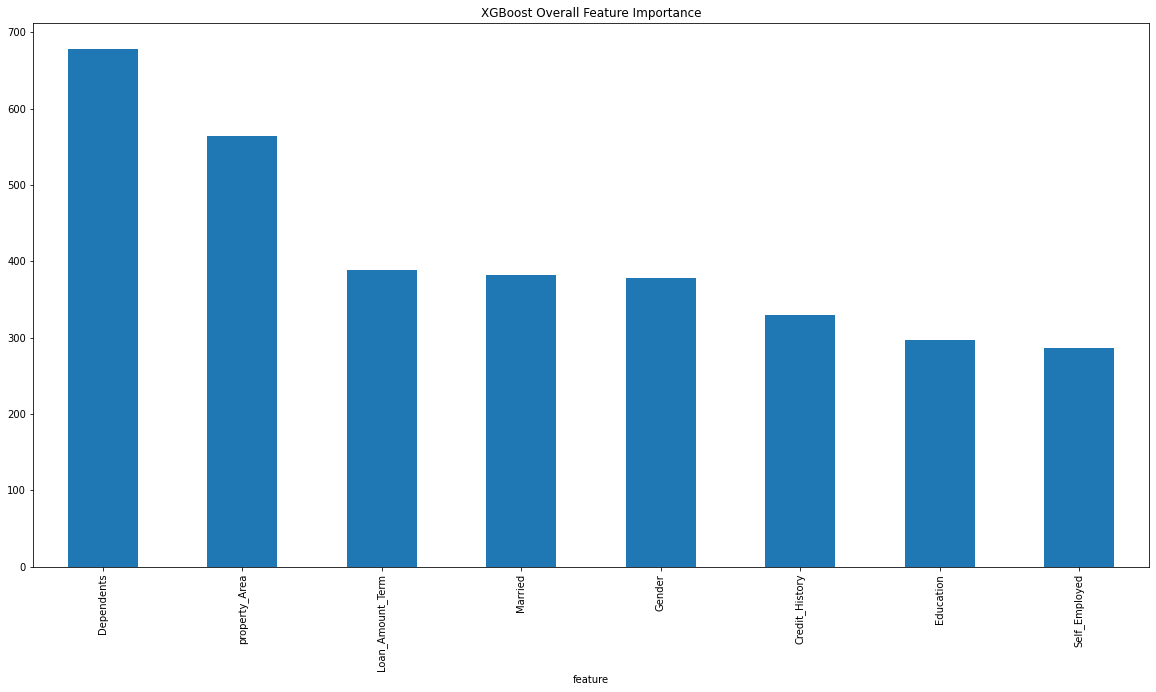

In [19]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [20]:
df.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
property_Area        0
dtype: int64

# **To Be Continued...**